## Sliding windows and missing data RAD-seq

In [1]:
# conda install ipcoal ipyrad -c conda-forge -c bioconda 

In [1]:
import numpy as np
import pandas as pd
import toytree
import toyplot, toyplot.svg
import ipcoal
import ipyrad.analysis as ipa

### Make working directory

In [2]:
! mkdir -p ./sandra

### Treestyle

In [2]:
#set the tree style
ts = {
    'ts': 'p', 
    'layout': 'r',
    'height': 300,
    'node_sizes': 7,
    'node_style': {"stroke": "black", 'stroke-width': 2},
    'node_labels': False,
    'edge_type': 'c',
    'tip_labels_align': True,
    'tip_labels_style': {"font-size":"15px"},
    'scalebar': True,
    'tip_labels_colors': ["maroon","red","orange","green","darkturquoise","dodgerblue","mediumblue","darkviolet"],
}

### Starting simulation scenario with deep divergences and some short internodes

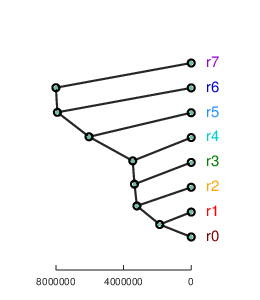

In [4]:
# get an ultrametric imbalanced tree with some short internal nodes
#get a topology with 8 tips and a tree height of 8,000,000 generations
tree = toytree.rtree.imbtree(ntips=8, treeheight=8e6)
tree = tree.mod.node_slider(0.99, seed=1234)
canvas, axes, mark = tree.draw(**ts);


# save to file
tree.write("./sandra/tree.nwk")
toyplot.svg.render(canvas,"./sandra/model_tree.svg")
canvas

### Simulate a concatenated sequence (chromosome) WITHOUT missing data

This needs to be made much longer for your purposes...

In [5]:
# simulate a long chrom
model = ipcoal.Model(tree, Ne=2e6, seed=123)
model.sim_loci(1, 1e6)


# Write data (without spacers) to SEQS HDF5 format
model.write_loci_to_hdf5(name="no_spacer", outdir="sandra")
model.df.to_csv("/rigel/dsi/users/slh2181/locus_length/toy_example/sandra/true_genealogies.csv")

wrote 1 loci to /rigel/dsi/users/slh2181/locus_length/toy_example/sandra/no_spacer.seqs.hdf5


In [6]:
# write to db
model.write_loci_to_hdf5(name="with_spacers", outdir="sandra")

wrote 1 loci to /rigel/dsi/users/slh2181/locus_length/toy_example/sandra/with_spacers.seqs.hdf5


In [7]:
# show the total number of genealogies
print('ngenealogies:', model.df.tidx.max())
print('mean len of gtree: {:.2f} bp'.format(model.df.nbps.mean()))

ngenealogies: 38938
mean len of gtree: 25.68 bp


### Confirm concatenation is in the anomaly zone 

Here we aim to select a scenario that will lie in the 'anomaly zone', where concatenation will yield incorrect results but a proper MSC method should infer a correct result.

In [8]:
# init raxml inference
tool = ipa.treeslider(
    data="./sandra/no_spacer.seqs.hdf5",
    name="concat",
    workdir="sandra",
    scaffold_idxs=0,
    inference_args={
        "f": "d",
        "N": 10,
        "p": 12345,
        "x": None,
        "T": 24,
    }
)
tool.ipcluster['threads'] = 24
tool.show_inference_command()

# infer concat tree
tool.run(auto=True, force=True)

/rigel/home/slh2181/miniconda3/bin/raxmlHPC-PTHREADS-AVX2 -f d -T 24 -m GTRGAMMA -n ... -w ... -s ... -p 12345 -N 10
building database: nwindows=1; minsnps=1
[####################] 100% 0:00:29 | inferring trees 
tree_table written to /rigel/dsi/users/slh2181/locus_length/toy_example/sandra/concat.tree_table.csv


In [15]:
toytree.tree(tool.tree_table.tree[0]).root("r7").draw()

(<toyplot.canvas.Canvas at 0x2aab2488bd10>,
 <toytree.Render.ToytreeMark at 0x2aab2487cad0>)

<svg class="toyplot-canvas-Canvas" height="275.0px" id="tb22896f20df745d1a04843267b63f8ad" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 275.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7

### Simulate a concatenated sequence WITH  missing data

In [16]:
# simulate a long chrom
modelmiss = ipcoal.Model(tree, Ne=2e6, seed=123)
modelmiss.sim_loci(1, 1e6)

In [17]:
#impute missing data
# assumed space between RAD tags
SPACER = 5000
CUTLEN = 5

# iterate over each RAD tag
for i in range(0, modelmiss.seqs.shape[2], SPACER):  # From 0 to nsites=1e5, by spacer? 
    
    # mask. [0-300=DATA][300-5300=SPACER]
    # start at 300, mask until 5000, then start at 5000+300, mask until 5000+5000...
    modelmiss.seqs[:, :, i+300: i+SPACER] = 9
    
    # allele dropout
    cseqs = modelmiss.seqs[:, :, i:i+CUTLEN]
    aseqs = modelmiss.ancestral_seq[0, i:i+CUTLEN]
    mask = np.any(cseqs != aseqs, axis=2)[0]
    modelmiss.seqs[:, mask, i:i+300] = 9

In [19]:
# Write data (without spacers) to SEQS HDF5 format
modelmiss.write_loci_to_hdf5(name="with_spacer", outdir="sandra")

wrote 1 loci to /rigel/dsi/users/slh2181/locus_length/toy_example/sandra/with_spacer.seqs.hdf5


### Confirm concatenation is in the anomaly zone 

Here we aim to select a scenario that will lie in the 'anomaly zone', where concatenation will yield incorrect results but a proper MSC method should infer a correct result.

In [20]:
# init raxml inference
tool2 = ipa.treeslider(
    data="./sandra/with_spacer.seqs.hdf5",
    name="concat_spacer",
    workdir="sandra",
    scaffold_idxs=0,
    inference_args={
        "f": "d",
        "N": 10,
        "p": 12345,
        "x": None,
        "T": 24,
    }
)
tool2.ipcluster['threads'] = 24
tool2.show_inference_command()

# infer concat tree
tool2.run(auto=True, force=True)

/rigel/home/slh2181/miniconda3/bin/raxmlHPC-PTHREADS-AVX2 -f d -T 24 -m GTRGAMMA -n ... -w ... -s ... -p 12345 -N 10
building database: nwindows=1; minsnps=1
[####################] 100% 0:00:48 | inferring trees 
tree_table written to /rigel/dsi/users/slh2181/locus_length/toy_example/sandra/concat_spacer.tree_table.csv


In [21]:
toytree.tree(tool2.tree_table.tree[0]).root("r7").draw()

(<toyplot.canvas.Canvas at 0x2aab248a41d0>,
 <toytree.Render.ToytreeMark at 0x2aab24a983d0>)

<svg class="toyplot-canvas-Canvas" height="275.0px" id="t84a8b798c8e24919880d331c5c683754" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 275.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r3 r4 r2 r5 r6 r7

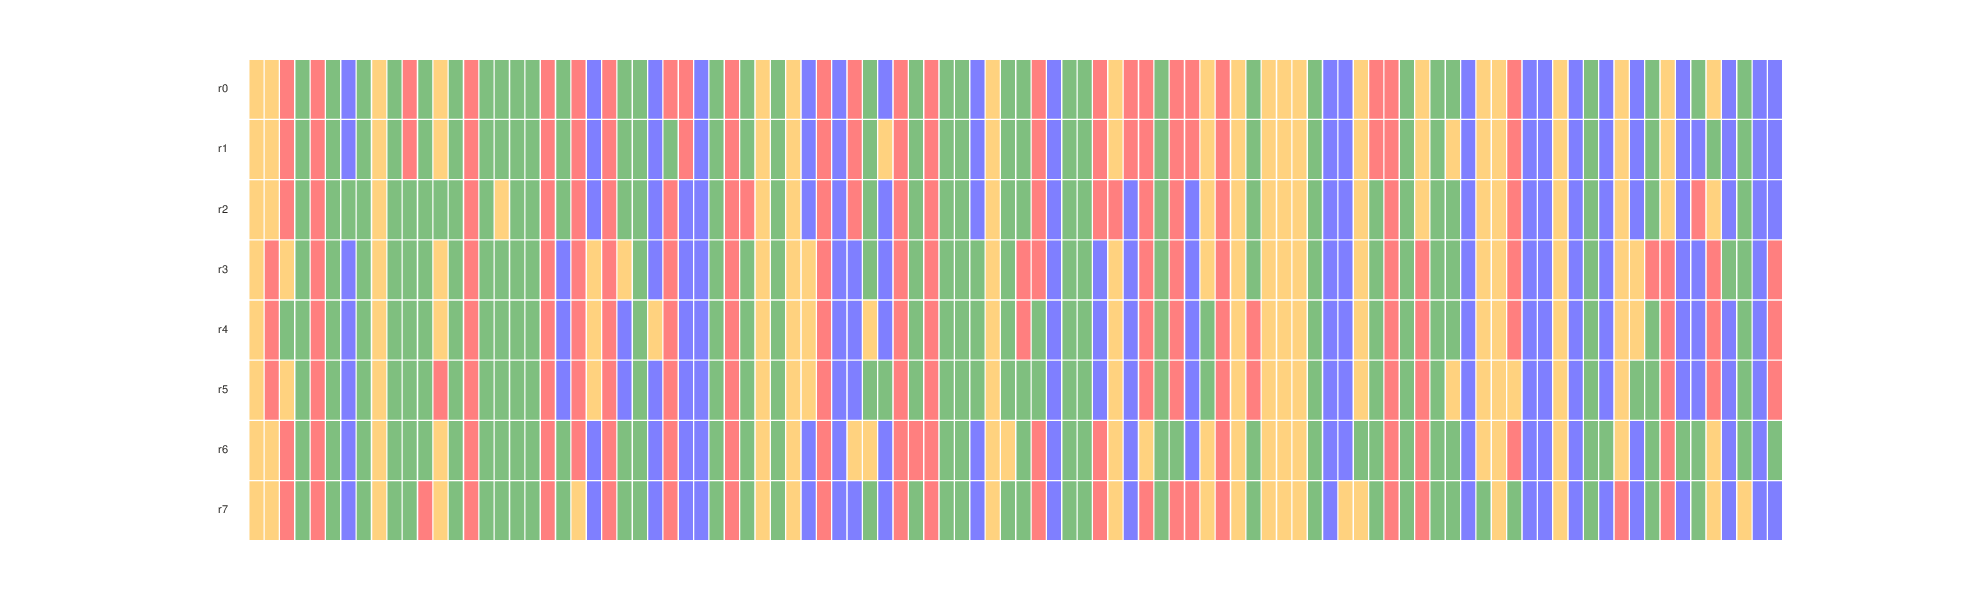

In [5]:
# check that data looks right, with sequence, including missing data on left and spacer on the right
canvas, axes = modelmiss.draw_seqview(0, 5250, 5350, height=600);

#write this to a file 
toyplot.svg.render(canvas, "/rigel/dsi/users/slh2181/locus_length/toy_example/sandra/seqview.svg")
canvas

In [18]:
# write to db
model.write_loci_to_hdf5(name="with_spacers", outdir="sandra")

wrote 1 loci to /rigel/dsi/users/slh2181/locus_length/toy_example/sandra/with_spacers.seqs.hdf5


In [6]:
# show the total number of genealogies
print('ngenealogies:', model.df.tidx.max())
print('mean len of gtree: {:.2f} bp'.format(model.df.nbps.mean()))

ngenealogies: 38938
mean len of gtree: 25.68 bp


### Confirm concatenation is in the anomaly zone 

Here we aim to select a scenario that will lie in the 'anomaly zone', where concatenation will yield incorrect results but a proper MSC method should infer a correct result.

In [7]:
# init raxml inference
tool = ipa.treeslider(
    data="./sandra/no_spacer.seqs.hdf5",
    name="concat",
    workdir="sandra",
    scaffold_idxs=0,
    inference_args={
        "f": "d",
        "N": 10,
        "p": 12345,
        "x": None,
        "T": 24,
    }
)
tool.ipcluster['threads'] = 24
tool.show_inference_command()

# infer concat tree
tool.run(auto=True, force=True)

/rigel/home/slh2181/miniconda3/bin/raxmlHPC-PTHREADS-AVX2 -f d -T 24 -m GTRGAMMA -n ... -w ... -s ... -p 12345 -N 10
building database: nwindows=1; minsnps=1
[####################] 100% 0:00:23 | inferring trees 
tree_table written to /rigel/dsi/users/slh2181/locus_length/toy_example/sandra/concat.tree_table.csv


In [11]:
# re-load the newick from treeslider output
tw = pd.read_csv("./sandra/concat.tree_table.csv")
ctree = toytree.tree(tw.tree[0]).root("r7")

# draw the concat tree
canvas, axes, mark = ctree.draw(**ts);

# save tree file
ctree.write("./sandra/concat.nwk")
toyplot.svg.render(canvas,"./sandra/concat_tree.svg")

canvas

### Simulate unlinked genealogies (Astral input)

In [9]:
# simulate many unlinked genealogies (same as above)
model = ipcoal.Model(tree, Ne=2e6, seed=123)
model.sim_trees(nloci=10000, nsites=1)

# load into a tree object and draw a few
mtre = toytree.mtree(model.df.genealogy)
mtre.draw();

# convert bl units to E(subst.)
for tre in mtre.treelist:
    for node in tre.idx_dict.values():
        node.dist = node.dist * 1e-8      

# write re-formatted trees to a tmp file
mtre.write("./sandra/genealogies.nwk")

<svg class="toyplot-canvas-Canvas" height="200.0px" id="tb8e3edb766994fa5910d0a855c4f6e85" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 560.0 200.0" width="560.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r1 r0 r3 r4 r2 r5 r7 r6 r1 r0 r4 r3 r2 r6 r5 r7 r4 r1 r3 r0 r7 r5 r2 r6 r4 r3 r2 r1 r0 r5 r6 r7

### Confirm ASTRAL-genealogy is not an anomaly


In [12]:
# infer MSC sptree with ASTRAL
ast = ipa.astral(
    data=[i.write() for i in toytree.mtree("./sandra/genealogies.nwk")],
    name="astral-genealogies",
)
ast.run()

# draw sptree
atree = toytree.tree(ast.tree).root("r7")
canvas, axes, mark = atree.draw(**ts);

# save tree file
atree.write("./sandra/astral-genealogies.nwk")
toyplot.svg.render(canvas,"./sandra/astral_tree.svg")

canvas

[astral.5.7.1.jar]
inferred tree written to (/rigel/dsi/users/slh2181/locus_length/toy_example/analysis-astral/astral-genealogies.tre)


### Confirm SNAQ-genealogies is not an anomaly

In [12]:
# infer sptree
snaq0 = ipa.snaq(
    gtrees="./sandra/genealogies.nwk",
    netin="./sandra/astral-genealogies.nwk",
    name="snaq-genealogies-net0",
    nedges=0,
    nruns=10,
    nproc=10,
    seed=123,
)
snaq0.run()

# infer sptree
snaq1 = ipa.snaq(
    gtrees="./sandra/genealogies.nwk",
    netin="./sandra/astral-genealogies.nwk",
    name="snaq-genealogies-net1",
    nedges=1,
    nruns=10,
    nproc=10,
    seed=123,
)
snaq1.run()

[SNAQ v.x.y]
[nproc = 10]
julia /home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genealogies-net0.jl
inferred network written to (/home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genealogies-net0.snaq)
[SNAQ v.x.y]
[nproc = 10]
julia /home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genealogies-net1.jl
inferred network written to (/home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genealogies-net1.snaq)


In [13]:
# last number is the inferred gamma
snaq1.admix

{'H9': (['r6', 'r7'], ['r0'], 0.5, {}, '0.006')}

In [14]:
# draw tree
stree = toytree.tree(snaq1.tree).root("r7")
stree.draw(**ts, admixture_edges=snaq1.admix.values());

# write network
stree.write("./sandra/snaq-genealogies.nwk")

<svg class="toyplot-canvas-Canvas" height="300.0px" id="tefe3966bd872434594cbc7f06c80add7" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 300.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.006 r0 r1 r2 r3 r4 r5 r6 r7 0 1 3

### Infer 10Kb window gene trees on the simulated chromosome


In [17]:
# init tree slider inference tool
tool = ipa.treeslider(
    data="./sandra/chrom-1e6.seqs.hdf5",
    name="windows-100K",
    workdir="sandra",
    window_size=100e3,
    slide_size=100e3,
    scaffold_idxs=0,
    inference_args={
        "N": 10,
        "f": "d",
        "p": 12345,
        "x": None,
        "T": 2,
    }
)

# infer all gene trees
tool.ipcluster['cores'] = 20
tool.ipcluster['threads'] = 2
tool.run(auto=True, force=True)

building database: nwindows=9; minsnps=1
[####################] 100% 0:00:23 | inferring trees 
tree_table written to /home/deren/gentime-attraction/notebooks/sandra/windows-100K.tree_table.csv


In [22]:
# load tree slider (gene tree inference) results
tw = pd.read_csv("./sandra/windows-100K.tree_table.csv", index_col=0)

# load gene trees into toytree multitree object
mtre = toytree.mtree(tw.tree)
mtre.treelist = [i.root("r7") for i in mtre.treelist]
mtre.draw(ts='o', use_edge_lengths=False);

# write list of trees as a tmp file
print(len(mtre), "gene trees")
mtre.write("./sandra/genetrees.nwk")

<svg class="toyplot-canvas-Canvas" height="200.0px" id="tfdb1ddf7ad0d4530bfb2e482d94d14d7" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 560.0 200.0" width="560.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r4 r3 r5 r6 r7 r0 r1 r2 r4 r3 r5 r6 r7 r0 r1 r3 r2 r4 r5 r6 r7 r0 r1 r3 r4 r2 r5 r6 r7

### Infer ASTRAL tree from inferred gene trees

In [23]:
# infer MSC sptree with ASTRAL
ast = ipa.astral(
    data=[i.write() for i in toytree.mtree("./sandra/genetrees.nwk")],
    name="astral-genetrees",
)
ast.run()

# draw sptree
atree = toytree.tree(ast.tree).root("r7")
atree.draw(**ts);

# save tree file
atree.write("./sandra/astral-genetrees.nwk")

[astral.5.7.1.jar]
inferred tree written to (/home/deren/gentime-attraction/notebooks/analysis-astral/astral-genetrees.tre)


<svg class="toyplot-canvas-Canvas" height="300.0px" id="t193c9913cada4b4286b5110d45ac7ac5" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 300.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r4 r3 r5 r6 r7 0 4 7

### Infer SNAQ network from inferred gene trees

In [24]:
snaq0 = ipa.snaq(
    gtrees="./sandra/genetrees.nwk",
    netin="./sandra/astral-genealogies.nwk",
    name="snaq-genetrees-net0",
    workdir="sandra",
    nedges=0,
    nruns=10,
    nproc=10,
)
snaq0.run()

snaq1 = ipa.snaq(
    gtrees="./sandra/genetrees.nwk",
    netin="./sandra/astral-genealogies.nwk",
    name="snaq-genetrees-net1",
    workdir="sandra",
    nedges=1,
    nruns=10,
    nproc=10,
)
snaq1.run()

[SNAQ v.x.y]
[nproc = 10]
julia /home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genetrees-net0.jl
inferred network written to (/home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genetrees-net0.snaq)
[SNAQ v.x.y]
[nproc = 10]
julia /home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genetrees-net1.jl
inferred network written to (/home/deren/gentime-attraction/notebooks/analysis-snaq/snaq-genetrees-net1.snaq)


In [25]:
# last value is gamma
snaq1.admix

{'H9': (['r0', 'r1'], ['r3'], 0.5, {}, '0.118')}

In [27]:
# draw tree
stree = toytree.tree(snaq1.tree).root("r7")
stree.draw(**ts, use_edge_lengths=False, admixture_edges=snaq1.admix.values());

<svg class="toyplot-canvas-Canvas" height="300.0px" id="tb2507df58e144ad488c302c197b9c1ee" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 300.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.118 r1 r0 r2 r3 r4 r5 r6 r7 0 3 6

### Repeat for other window sizes ...